In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from util import *
%matplotlib inline

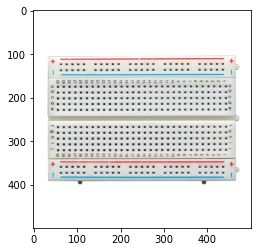

In [408]:
#img = cv2.imread('images/breadboard_plain.jpeg')
#img = cv2.imread('images/simple.jpg')
img = cv2.imread('images/bb1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display img
plt.imshow(img)
plt.show()


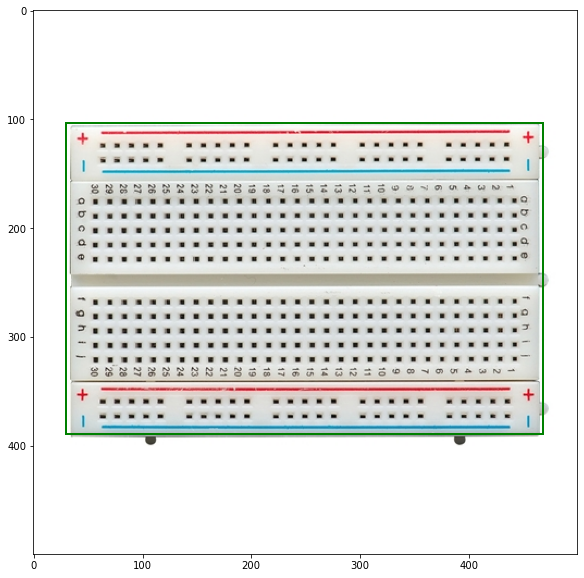

In [409]:
#input_boxes = [[67, 62, 590, 407]]
#input_boxes = [[129, 115, 1717, 1108]]
input_boxes = [[30, 103, 468, 389]]
show_boxes_on_image(img, input_boxes)

In [410]:
class Breadboard:
    # i might need to initialize the grid w.r.t with the breadboard coordinates, not image coordinates
    # because in the future, i might combine multiple images
    # connection should have a name
    
    def __init__(self, has_power_rails=True, grid=None):
        self.has_power_rails = has_power_rails
        self.num_rows = 10 # not including power rails
        self.num_cols = None # not including power rails
        self.grid = grid # middle of the breadboard (no power rails)

In [411]:
def identify_raw_keypoints(img, bounding_box):
    num_rows = None
    num_cols = None
    grid = None

    # identify blobs in the image and constrain them to the input boxes
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(img)

    # delete keypoints if they are not in the input boxes
    keypoints = [kp for kp in keypoints if kp.pt[0] > input_boxes[0][0] and kp.pt[0] < input_boxes[0][2] and kp.pt[1] > input_boxes[0][1] and kp.pt[1] < input_boxes[0][3]]

    # sort keypoints by y coordinate
    keypoints.sort(key=lambda x: x.pt[1])
    keypoints = [kp.pt for kp in keypoints]
    keypoints = np.array(keypoints, dtype=np.int32)

    # print the total number of keypoints
    show_points_on_image(img, keypoints)
    print("Total number of keypoints: {}".format(len(keypoints)))

    return keypoints

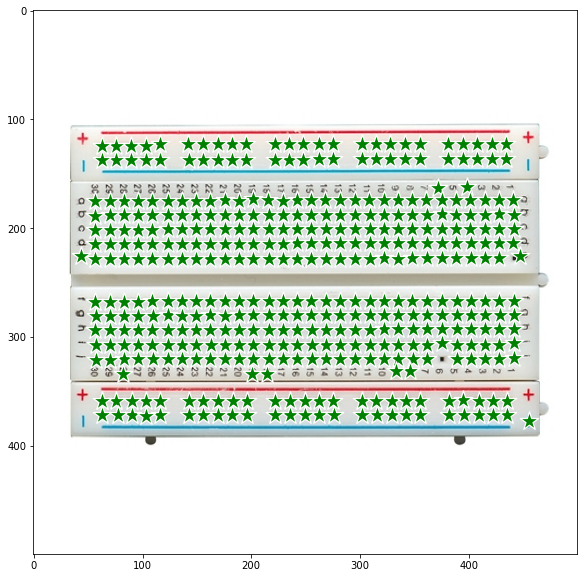

Total number of keypoints: 408


In [412]:
raw_keypoints = identify_raw_keypoints(img, input_boxes)

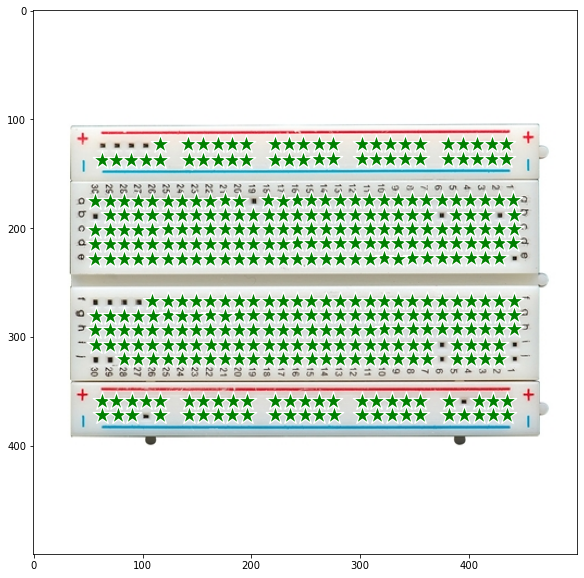

In [413]:
def process_keypoints(raw_keypoints):
    # removing outliers
    # count unique y coordinates and how many times they appear
    # save as array of tuples (y, count)
    x_counts = np.unique(raw_keypoints[:, 0], return_counts=True)
    x_counts = np.array(x_counts).T
    y_counts = np.unique(raw_keypoints[:, 1], return_counts=True)
    y_counts = np.array(y_counts).T

    #print("x_counts:\n {}".format(x_counts))
    #print("y_counts:\n {}".format(y_counts))

    # assemble a dictionary, where the key is the y coordinate and the value is a list of x coordinates
    # for example {79: [229, 262, 327, ...]}
    y_dict = {}
    for y_count in y_counts:
        y = y_count[0]
        count = y_count[1]
        x_coords = raw_keypoints[raw_keypoints[:, 1] == y][:, 0]
        x_coords.sort()
        y_dict[y] = x_coords

    #print("y_dict:\n {}".format(y_dict))

    # assemble a similar dictionary, but for x coordinates
    x_dict = {}
    for x_count in x_counts:
        x = x_count[0]
        count = x_count[1]
        y_coords = raw_keypoints[raw_keypoints[:, 0] == x][:, 1]
        y_coords.sort()
        x_dict[x] = y_coords

    y_values = list(y_dict.keys())

    # from sorted y_values, find the distances between neighboring y_values
    distances = {}
    for i in range(len(y_values) - 1):
        distance = y_values[i+1] - y_values[i]
        # count is how many elements that y_value has in y_dict
        count = len(y_dict[y_values[i]])
        if count < 5:
            continue
        distances[y_values[i]] = [distance, count]
    distances = sorted(distances.items(), key=lambda x: x[1][1], reverse=True)
    # sort by key
    distances = sorted(distances, key=lambda x: x[0])
    #print("distances:\n {}".format(distances))

    temp_keypoints = []
    for distance in distances:
        y = distance[0]
        x_coords = y_dict[y]
        for x in x_coords:
            temp_keypoints.append((x, y))

    show_points_on_image(img, temp_keypoints)

    return temp_keypoints


processed_keypoints = process_keypoints(raw_keypoints)

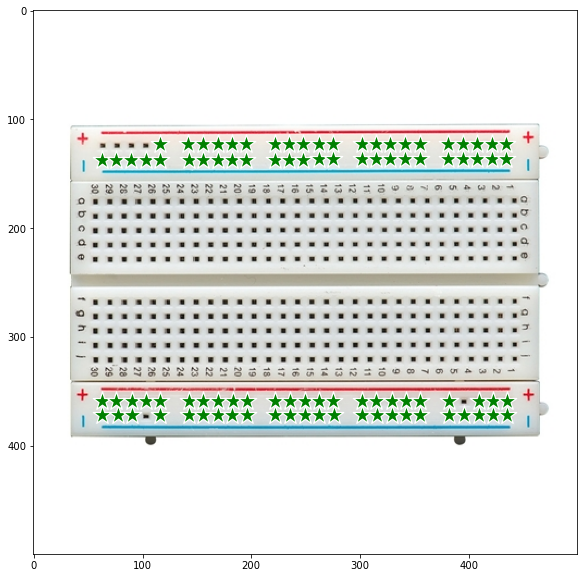

[[(116, 123),
  (142, 123),
  (156, 123),
  (169, 123),
  (182, 123),
  (195, 123),
  (222, 123),
  (235, 123),
  (248, 123),
  (262, 123),
  (275, 123),
  (302, 123),
  (315, 123),
  (328, 123),
  (341, 123),
  (355, 123),
  (381, 123),
  (395, 123),
  (408, 123),
  (421, 123),
  (434, 123)],
 [(63, 137),
  (76, 137),
  (89, 137),
  (103, 137),
  (116, 137),
  (143, 137),
  (156, 137),
  (169, 137),
  (182, 137),
  (195, 137),
  (222, 137),
  (235, 137),
  (248, 137),
  (262, 136),
  (275, 136),
  (302, 136),
  (315, 136),
  (328, 136),
  (341, 136),
  (355, 136),
  (381, 136),
  (395, 136),
  (408, 136),
  (421, 136),
  (434, 136)],
 [(63, 372),
  (77, 372),
  (90, 372),
  (116, 372),
  (143, 372),
  (156, 372),
  (169, 372),
  (182, 372),
  (196, 372),
  (222, 372),
  (236, 372),
  (249, 372),
  (262, 372),
  (276, 372),
  (302, 372),
  (316, 372),
  (329, 372),
  (342, 372),
  (355, 372),
  (382, 372),
  (396, 372),
  (409, 372),
  (422, 372),
  (435, 372)],
 [(63, 359),
  (76, 359

In [440]:
def detect_power_rails(processed_keypoints):
    kps = processed_keypoints.copy()
    # sort kps by y coordinate
    kps.sort(key=lambda x: x[1])
    
    y_coords = [kp[1] for kp in kps]
    y_coords = np.unique(y_coords)

    y_rails = []
    y_counter = 0
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter + 1]
        if neighbor - y_coord < 3:
            rail.append(neighbor)
            y_counter += 2
        else:
            y_counter += 1
        y_rails.append(rail)

    y_counter = -1
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter - 1]
        if y_coord - neighbor < 3:
            rail.append(neighbor)
            y_counter -= 2
        else:
            y_counter -= 1
        y_rails.append(rail)

    # return an array of 4 elements, each of which contains (x, y) coordinates corresponding to the power rail
    rails = []
    for y_rail in y_rails:
        rail = []
        # rail will contain (x, y) coordinates corresponding to the power rail
        # takes all values corresponding to the y_rail key
        rail = [kp for kp in kps if kp[1] in y_rail]

        # sort rail by x coordinate
        rail.sort(key=lambda x: x[0])
        rails.append(rail)

    rail_keypoints = []
    for i in range(len(rails)):
        for j in range(len(rails[i])):
            rail_keypoints.append(rails[i][j])

    show_points_on_image(img, rail_keypoints)
    
    return rails
    

detect_power_rails(processed_keypoints)

In [313]:
def identify_breadboard(img, bounding_box):

    # print two smallest and largest y coordinates
    y_coords = list(y_dict.keys())
    y_coords.sort()
    powerline_y_coords = y_coords[:2] + y_coords[-2:]
    print("\nPowerline y coordinates: {}".format(powerline_y_coords))

    # grid is the same as y_dict, but without the powerlines
    grid = y_dict.copy()
    for y_coord in powerline_y_coords:
        del grid[y_coord]

    # how many grid keys are there
    num_grid_rows = len(grid.keys())
    if num_grid_rows != 10:
        print("\U0000274C Warning: number of grid rows is not 10, but {}".format(num_grid_rows))
    else:
        print("\U00002705 Row check successful: Number of grid rows is 10")

    grid_keypoints = []
    for y, x_coords in grid.items():
        for x in x_coords:
            grid_keypoints.append([x, y])
    
    #show_points_on_image(img, grid_keypoints)

    # print average number of keypoints per row
    num_keypoints = 0
    for y, x_coords in grid.items():
        num_keypoints += len(x_coords)
    avg_num_keypoints = num_keypoints / len(grid.keys())

    num_cols = int(avg_num_keypoints)
    print(num_cols)

    # print the total number of keypoints in the grid
    print("Total number of keypoints in the grid: {}".format(num_keypoints))

    grid_connects = []
    # grid_connects is a list of lists (each of them is 5 elements long)
    # there are num_cols * 2 elements in grid_connects
    # fill grid_connects from left to right, top to bottom, taking coordinates from grid dictionary
    # for example, the first element of grid_connects is grid[143][0], grid[159][0], grid[176][0], grid[192][0], grid[208][0]
    # row_indices is all keys of grid dictionary sorted
    row_indices = list(grid.keys())
    row_indices.sort()

    left_average, right_average = 0, 0
    left_total, right_total = 0, 0
    for i in row_indices:
        grid[i].sort()
        left_total += grid[i][0]
        right_total += grid[i][-1]
    left_average = left_total/len(row_indices)
    right_average = right_total/len(row_indices)

    # remove the x coordinate from the values dictionary if the first x coordinate is less than the left average
    # and the last x coordinate is greater than the right average
    for i in row_indices:
        if grid[i][0] < left_average:
            grid[i] = grid[i][1:]
        if grid[i][-1] > right_average:
            grid[i] = grid[i][:-1]

    # iterate over the grid dictionary
    # for each key, iterate over the values and see if the distance between the neighboring values is less than 5 pixels
    # if it is, then delete the value
    for i in row_indices:
        for j in range(len(grid[i]) - 1):
            if grid[i][j + 1] - grid[i][j] < 5:
                # remove grid[i][j] from grid[i]
                grid[i] = np.delete(grid[i], j)
                print("Removed {} from grid[{}]".format(grid[i][j], i))
                break

    grid_keypoints = []
    for y, x_coords in grid.items():
        for x in x_coords:
            grid_keypoints.append([x, y])

    # print the number of keypoints in each row
    for y, x_coords in grid.items():
        print("y: {}, number of keypoints: {}".format(y, len(x_coords)))

    show_points_on_image(img, grid_keypoints)

    grid_connects = []
    # iterate over the first 5 row indices
    for i in range(num_cols):
        grid_connect = []
        for j in row_indices[:5]:
            x = grid[j][i]
            y = j
            grid_connect.append((x, y))
        grid_connects.append(grid_connect)
       
        grid_connect = []
        for j in row_indices[5:]:
            x = grid[j][i]
            y = j
            grid_connect.append((x, y))
        grid_connects.append(grid_connect)
        
    print(grid_connects)

    # print the number of grid connects
    print("Number of grid connects: {}".format(len(grid_connects)))

    return Breadboard(grid=grid_connects)

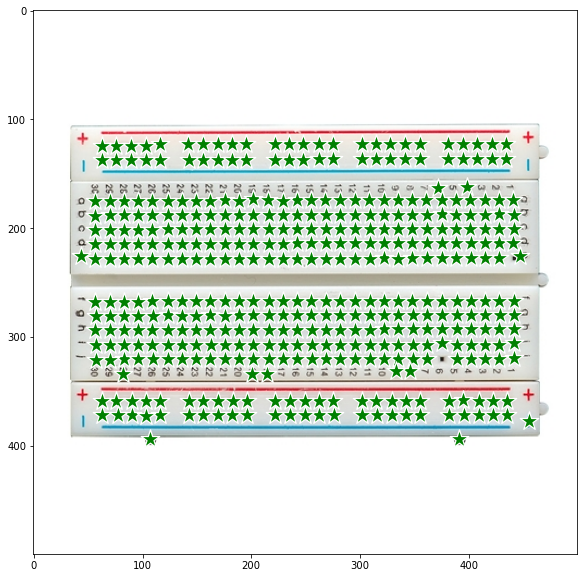

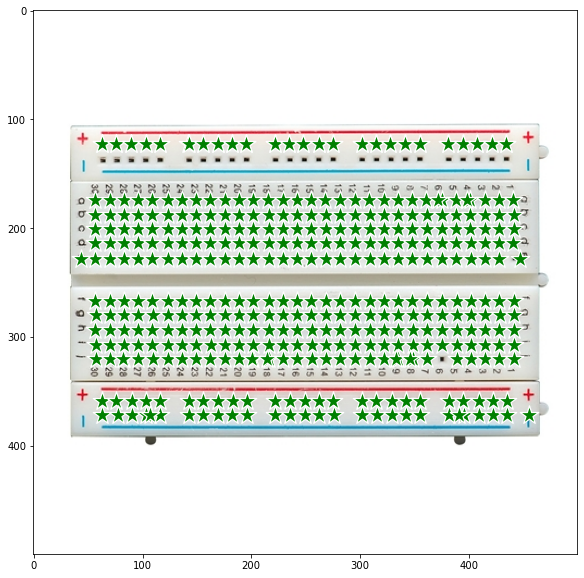


Powerline y coordinates: [123, 174, 359, 372]
❌ Warning: number of grid rows is not 10, but 9
30
Total number of keypoints in the grid: 275
Removed 83 from grid[320]
y: 188, number of keypoints: 30
y: 201, number of keypoints: 30
y: 214, number of keypoints: 30
y: 228, number of keypoints: 29
y: 267, number of keypoints: 30
y: 280, number of keypoints: 30
y: 294, number of keypoints: 30
y: 307, number of keypoints: 30
y: 320, number of keypoints: 33


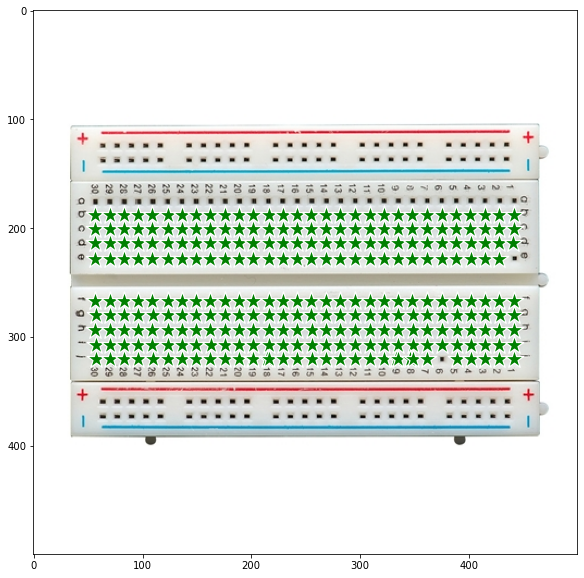

IndexError: index 29 is out of bounds for axis 0 with size 29

In [314]:
bb = identify_breadboard(img, input_boxes[0])

In [297]:
bb.grid

[[(91, 143), (91, 159), (91, 176), (90, 192), (91, 208)],
 [(91, 256), (91, 273), (91, 289), (91, 305), (91, 322)],
 [(107, 143), (107, 159), (107, 176), (107, 192), (107, 208)],
 [(107, 256), (107, 273), (107, 289), (107, 305), (107, 322)],
 [(123, 143), (123, 159), (123, 176), (123, 192), (123, 208)],
 [(123, 256), (123, 273), (123, 289), (123, 305), (123, 322)],
 [(139, 143), (140, 159), (139, 176), (139, 192), (139, 208)],
 [(139, 256), (140, 273), (140, 289), (140, 305), (140, 322)],
 [(156, 143), (155, 159), (156, 176), (155, 192), (155, 208)],
 [(156, 256), (156, 273), (156, 289), (156, 305), (156, 322)],
 [(172, 143), (172, 159), (172, 176), (172, 192), (171, 208)],
 [(172, 256), (172, 273), (172, 289), (172, 305), (172, 322)],
 [(188, 143), (188, 159), (188, 176), (188, 192), (188, 208)],
 [(188, 256), (188, 273), (188, 289), (188, 305), (188, 322)],
 [(204, 143), (204, 159), (204, 176), (204, 192), (204, 208)],
 [(204, 256), (205, 273), (205, 289), (205, 305), (205, 322)],
 [

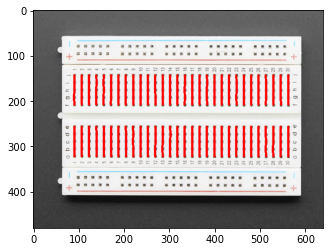

In [299]:
# based on bb.grid:
# connect together the 5 points within each element in bb.grid
# draw the lines on the original image and display it
# use cv2.line

for elem in bb.grid:
    for i in range(len(elem) - 1):
        x1, y1 = elem[i]
        x2, y2 = elem[i + 1]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(img)
plt.show()

